# Sparkify Project

This notebook can be used locally with a tiny subset of dataset (128MB) or with amedium sized dataset (243MB). Alternatively this notebook can also be run on a AWS server instance - in this case beside the tiny dataset (128MB) there is also full dataset (about 12GB) available.


You can follow the steps below to read, clean and explore the dataset. Followed by feature extraction and creation of different Machine Learning models.

**Attention:** Running this notebook completely might be time consuming.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, last, when, sum, mean, col, ceil, struct
from pyspark.sql.types import IntegerType, LongType, DoubleType
from pyspark.sql.functions import avg, col, concat, count, desc, explode, lit, min, max, split, stddev, udf
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
import pyspark.sql.functions as F

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
def create_spark_session(local=True):
    '''
    Input:
        local - (boolean) flag that indicates if the Spark session should
                run locally or on Amazon Web Services (AWS)
    Output:
        spark - (spark session) returns the created Spark session
    '''
    if local:
        # create a local spark session
        spark = SparkSession.builder \
                .master("local") \
                .appName("Sparkify") \
                .getOrCreate()
    else:
        # create an AWS spark session 
        spark = SparkSession \
                .builder \
                .appName("Sparkify") \
                .getOrCreate()
    return spark

In [3]:
# create session
spark = create_spark_session(local=True)
spark

# Load and Clean Dataset
In this section the dataset will be loaded from file depending on the choosen Sparksession and preferred dataset size. Then data cleaning as a first preprocessing step is applied to the data. 

##### Overview: Dataset variables

* **userId** (string): User identification nuber 
* **page** (string): Kind of page accessed e.g. downgrade/upgrade/next song/...
* **registration** (string): Date of the registration 
* **ts** (string): Timestamp the the recored event. 
* **level** (string): Account type - free or payed.
* **status** (string): HTTP status code of the page event.
* **method** (string): HTTP request type - GET or POST
* **gender** (string): Gender of the user.
* **sessionId** (string): Unique Id of each session.
* **auth** (string): Indicates if the user was logged in.
* **firstName** (string): First name of the user.
* **lastName** (string): Last name of the user.
* **location** (string): Geographical location of the user.
* **userAgent** (string): Contains information about the used browser and operating system.
* **itemInSession** (string): Number of items in current sesseion.
* **song** (string): Name of a song.
* **artist** (string): Name of the artist. 
* **length** (string): Length (minutes) of the song 

In [4]:
def load_data(session=spark, small=True):
    '''
    Input:
        sesssion - (Spark session) current Spark session
        small - (boolean) flag if the small dataset should be used 
                if the value is true the medium/fulldataset is used
    Output:
        df - (Spark dataframe) returns the loaded dataframe
    '''
    # specify file path of the dataset
    if session.sparkContext.getConf().getAll()[0][1] == "local": 
        if small:
            sparkify_data = "mini_sparkify_event_data.json"
        else:
            sparkify_data = "medium_sparkify_event_data.json"
    else:
        if small:
            sparkify_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
    
        else:
            sparkify_data = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
    
    # read the dataset
    df = session.read.json(sparkify_data)
    return df

In [5]:
def clean_data(df):
    '''
    Input:
        df - (Spark dataframe) dataframe which should be cleaned
    
    Output: 
        df - (Spark dataframe) returns the cleaned dataframe
    
    Description:
    This function cleans a dataset. The columns in the dataset can be devided into
    the following three categories:
    
    1. Required variables: NA-values must be prevented
    
    - userId -> identifying the user
    - page -> which page was accessed: e.g. downgrade/upgrade/next song
    - registration: the date of the registration 
    - ts -> needed for analyzing the user activity during the day 
    - level -> free/paid: needed for analyzing the churn rate
    - status -> HTTP status codes: check if user is unsatisfied with Sparkify's availability 
    - method -> HTTP request type: check if user is unsatisfied with Sparkify's availability
    - gender -> check if there is a different behaviour for different gender
    - sessionId -> assures the session was valid

    2. Nice to have , but not necessary relevant variables:
    - auth -> "Cancalled / Logged In"
    - firstName -> first name of te user
    - lastName -> last name of the user
    - location -> user geographical location
    - userAgent -> difference between Win/Mac users / browser
    - itemInSession

    3. Variables where NA-valus are acceptable (depending on the page event):
    - song -> name of the played song
    - artist -> name of the artist 
    - length -> length of the song (do not remove NA's here or the column page only contains "next page")
    '''
    # drop all NA-values in columns of the first category
    df_clean = df.dropna(how = "any", subset = ["userId", "sessionId", "method", "page", "ts", 
                                                "registration", "level", "userAgent", "method",
                                                "status"])
    
    # cleaning the gender column - assuming the null values can be either null or an other gender
    # during feature engineering all genders will be converted to numerical values
    df_clean = df_clean.fillna("null/other", subset=["gender"])

    # filter userIds with an empty string
    df_clean = df_clean.filter(df_clean["userId"] != "")

    # user defined function to extract the play hour from the timestamp
    get_hour = udf(lambda x: datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
    
    # create the a new column "hour" this keeps the hour when a user interacted with the system
    df_clean = df_clean.withColumn("hour", get_hour(df.ts))
    
    # print basic stats (size)
    size_orig = df.count()
    size_clean = df_clean.count()
    print("Dataset inital size: {}".format(size_orig))
    print("Dataset size after cleaning process: {} (removed {} entries)".format(size_clean, size_orig - size_clean))
    
    return df_clean

In [6]:
def load_and_clean_data(spark, small=True):
    df = load_data(spark, small)
    df = clean_data(df)
    return df

In [7]:
# load dataset and clean the data
df = load_and_clean_data(spark, small=True)
df.persist()

Dataset inital size: 286500
Dataset size after cleaning process: 278154 (removed 8346 entries)


DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, hour: int]

# Exploratory Data Analysis

In this section the cleaned dataset will be analysed.
* Preliminary Analysis: first look in the data
* Feature Creation: chrun, downgrade, browser and operating system
* Data Exploration with the created features


## Preliminary Analysis
The following part covers a basic analysis of Sparkify's user data.

In [8]:
# take a first quick look at the dataset schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = false)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: integer (nullable = true)



In [9]:
# get the number of records
total_records = df.count()
print("The dataset contains {} records.".format(total_records))

The dataset contains 278154 records.


In [10]:
# number of users
num_users = df.select("userId").dropDuplicates().count()
print("The dataset contains {} users.".format(num_users))

The dataset contains 225 users.


#### User Groups (paid and unpaid memberships)
In this section the difference between paid and unpaid memberhips are shown. Since the users can change its membership status over time here all entries of the dataset are used.

In [11]:
# get membership data
pd_user_level = df.groupby("level").count().toPandas()
pd_user_level

,level,count
0,free,55721
1,paid,222433


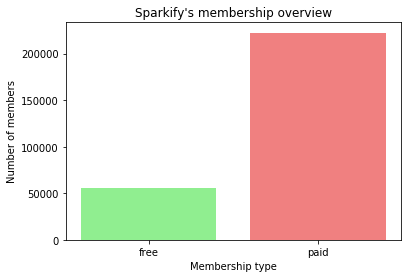

In [12]:
# plot memberhsip data
plt.figure();
plt.bar(pd_user_level.level.values, pd_user_level["count"], color=["lightgreen", "lightcoral"]);
plt.xlabel("Membership type");
plt.ylabel("Number of members");
plt.title("Sparkify's membership overview");

In [13]:
# calculate the percentages
free_percentage = pd_user_level["count"][0] / total_records
paid_percentage = 1 - free_percentage
print("Membership overview:"+
      "\n free: {:.2f}% ({})\n paid: {:.2f}% ({})".format(free_percentage, pd_user_level["count"][0], 
                                                          paid_percentage, pd_user_level["count"][1]))

Membership overview:
 free: 0.20% (55721)
 paid: 0.80% (222433)


#### User groups: gender
Are Sparkify's user equally distributed between all genders:

In [14]:
# get Sparkify users grouped by their gender
pd_gender = df.dropDuplicates(["userId"]).groupby("gender").count().toPandas()
pd_gender.gender = pd_gender.gender.apply(lambda x: "female" if x == "F" else "male")

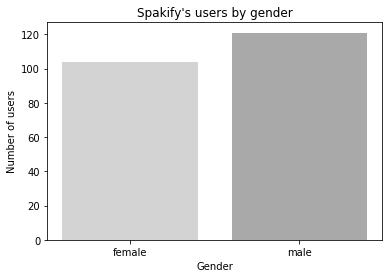

In [15]:
plt.figure();
plt.bar(pd_gender["gender"], pd_gender["count"], color=["lightgray", "darkgray"]);
plt.ylabel("Number of users");
plt.xlabel("Gender");
plt.title("Spakify's users by gender");

In [16]:
pd_gender

,gender,count
0,female,104
1,male,121


In [17]:
# percentage of female users
female_users = 104 / 225
# percentage of male users
male_users = 121 / 225

print("male users: {:.2f}%".format(male_users*100))
print("female users: {:.2f}%".format(female_users*100))
print("difference in gender: {:.2f}%".format((female_users - male_users)*100))

male users: 53.78%
female users: 46.22%
difference in gender: -7.56%


#### User activity: gender
Which user groupy produces more traffic on Sparkify?

In [18]:
# get Sparkify users grouped by their gender
pd_gender = df.groupby("gender").count().toPandas()
pd_gender.gender = pd_gender.gender.apply(lambda x: "female" if x == "F" else "male")

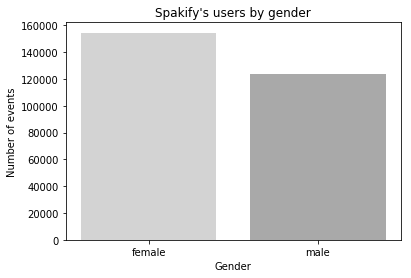

In [19]:
plt.figure();
plt.bar(pd_gender["gender"], pd_gender["count"], color=["lightgray", "darkgray"]);
plt.ylabel("Number of events");
plt.xlabel("Gender");
plt.title("Spakify's users by gender");

In [20]:
# percentage of female users
female_users = pd_gender["count"][0]/ total_records
# percentage of male users
male_users = pd_gender["count"][1] / total_records

print("male users: {:.2f}%".format(male_users*100))
print("female users: {:.2f}%".format(female_users*100))
print("difference in gender: {:.2f}%".format((female_users - male_users)*100))

male users: 44.43%
female users: 55.57%
difference in gender: 11.15%


#### Playtime over the day
Discover the playtime over the day in respect to the following groups:

* all users
* gender
* payed / unpaid

In [21]:
# load the playtime data for all groups into pandas dataframes 
pd_playtime_all = df.groupby("hour").count().sort("hour").toPandas()
pd_playtime_paid = df.where("level == 'paid'").groupby("hour").count().sort("hour").toPandas()
pd_playtime_unpaid = df.where("level != 'paid'").groupby("hour").count().sort("hour").toPandas()
pd_playtime_men = df.where("gender == 'M'").groupby("hour").count().sort("hour").toPandas()
pd_playtime_female = df.where("gender == 'F'").groupby("hour").count().sort("hour").toPandas()

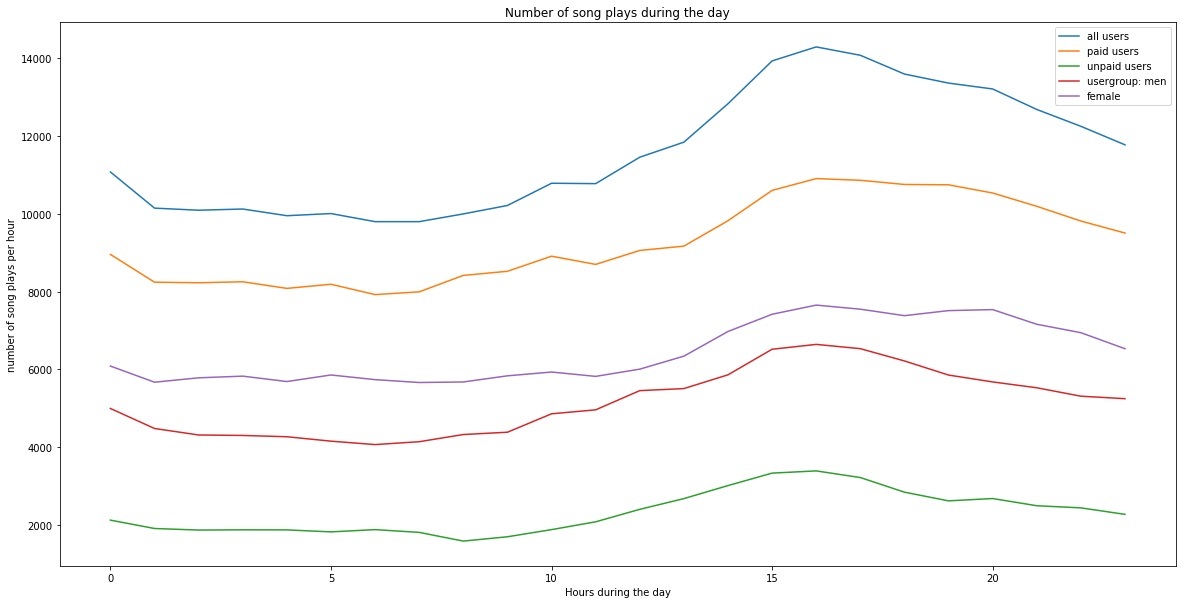

In [22]:
# visualize the playtime over the day grouped by the user group
plt.figure(figsize=[20,10]);
plt.plot(pd_playtime_all["count"], label="all users");
plt.plot(pd_playtime_paid["count"], label="paid users");
plt.plot(pd_playtime_unpaid["count"], label="unpaid users");
plt.plot(pd_playtime_men["count"], label="usergroup: men");
plt.plot(pd_playtime_female["count"], label="female")
plt.xlabel("Hours during the day");
plt.ylabel("number of song plays per hour");
plt.title("Number of song plays during the day")
plt.legend();

#### Memberhship downgrades/upgrades

Exploring the membership up- and downgrades.

In [23]:
# count page event for each entry in the log file
df.groupby("page").count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [24]:
# number of downgrades
num_downgrades = df.where("page = 'Submit Downgrade'").count()
num_downgrades_unique = df.where("page = 'Submit Downgrade'").dropDuplicates().count()
print("The total number of downgrades is {} from {} different users".format(num_downgrades,
                                                                            num_downgrades_unique))

The total number of downgrades is 63 from 63 different users


In [25]:
# number of upgrades
num_upgrades = df.where("page = 'Submit Upgrade'").count()
num_upgrades_unique = df.where("page = 'Submit Upgrade'").dropDuplicates().count()
print("The total number of upgrades is {} from {} different users".format(num_upgrades,
                                                                          num_upgrades_unique))

The total number of upgrades is 159 from 159 different users


#### Location
This section covers a quick look at the location of Sparkify's users

In [26]:
# use only the last two characters from the location indicating the state
split_location = udf(lambda x: re.split(" ", x)[-1])

In [27]:
# get location of each user
pd_states = df.dropDuplicates(["userId"]).withColumn("state", split_location(df.location))\
                                         .groupby("state").count().toPandas()

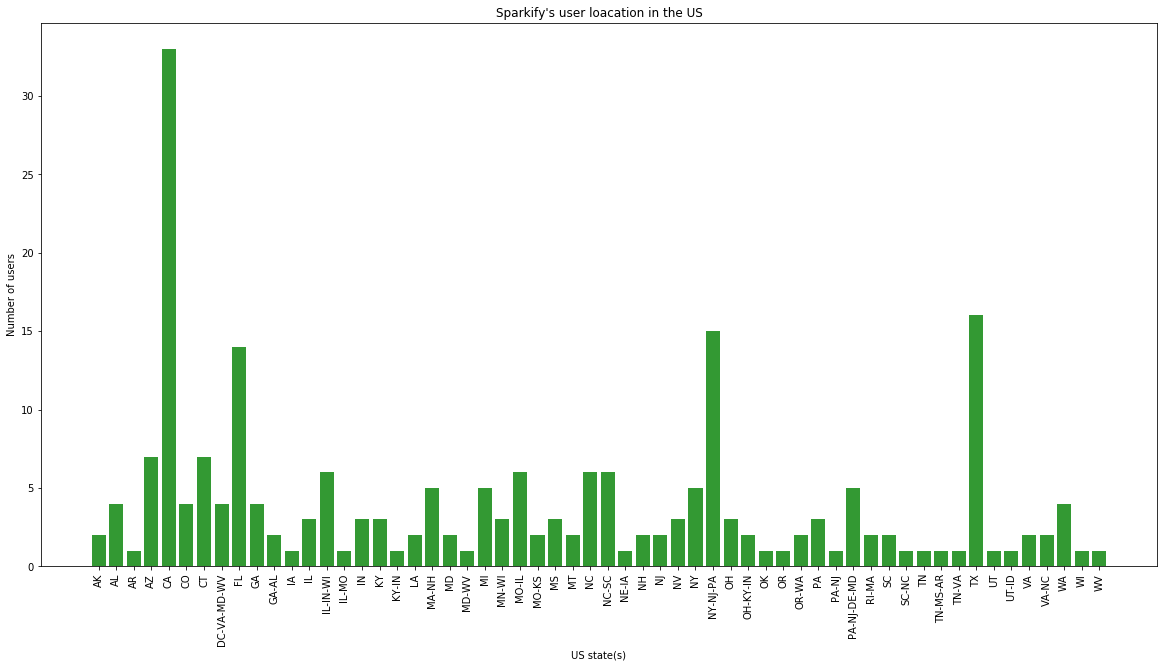

In [28]:
# bar chart of the locations
plt.figure(figsize=[20,10]);
plt.bar(pd_states.state, pd_states["count"], color="green", alpha=0.8);
plt.xlabel("US state(s)");
plt.ylabel("Number of users");
plt.title("Sparkify's user loacation in the US");
plt.xticks(rotation=90);

In [29]:
# stats for the location
pd_states["count"].describe()

count    58.00000
mean      3.87931
std       5.06130
min       1.00000
25%       1.00000
50%       2.00000
75%       4.00000
max      33.00000
Name: count, dtype: float64

The users declared 58 different locations in the US - some locations consists of several US states. There are three areas with an higher user occurence.

* California on the west coast
* East coast area: New York, New Jersey and Pennsylvania
* South states with Texas and Florida

#### Artist and song 
Most played artist and song:

In [30]:
# most played artists
df.where(col("artist").isNotNull()).groupby("artist").count().sort("count", ascending=False).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
|       Guns N' Roses|  713|
+--------------------+-----+
only showing top 20 rows



In [31]:
# get the most played songs
df.where(col("song").isNotNull()).groupby("song").count().sort("count", ascending=False).show()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
|    Ain't Misbehavin|  409|
|       ReprÃÂ©sente|  393|
|SinceritÃÂ© Et J...|  384|
|Catch You Baby (S...|  373|
|              Yellow|  343|
|    Somebody To Love|  343|
|    Hey_ Soul Sister|  334|
|            The Gift|  327|
|           Fireflies|  312|
|          Love Story|  309|
+--------------------+-----+
only showing top 20 rows



In [32]:
# get the artist of the most played song
df.select(["artist", "song"]).filter(df.song.like("You're The One")).dropDuplicates().show()

+--------------------+--------------+
|              artist|          song|
+--------------------+--------------+
|                 SWV|You're The One|
|       Dwight Yoakam|You're The One|
|      The Black Keys|You're The One|
|Daedelus Featurin...|You're The One|
|Blood_ Sweat & Tears|You're The One|
|         Buddy Holly|You're The One|
|          The Vogues|You're The One|
+--------------------+--------------+



Note: There are a lot of entries without an artist or song title, more precisely 50046 entries (in the small dataset). These entries represent the page event excluding "Next song" which are other activities on the Sparkify platform.

In [33]:
# number of page events where the artist and song are null
num_page_event = total_records - df.filter(df.artist.isNotNull()).count()
num_page_event

50046

In [34]:
# number of page events where the artist is not null
num_artist_events = df.dropna(how = "any", subset = ["artist"]).groupby("page").count().head()[1]
num_artist_events

228108

In [35]:
# check if the artist and page events sum up to total record number -> true
num_artist_events + num_page_event == total_records

True

#### Technical issues
Take a look how often there are technical proplems on the Sparify platform - based on the http status codes

In [36]:
# get the HTTP status codes
pd_http_status = df.groupby("status").count().toPandas()
pd_http_status

,status,count
0,307,23184
1,404,252
2,200,254718


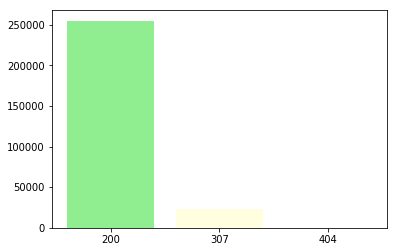

In [37]:
# bar chart of the HTTP status
plt.figure();
plt.bar(["307", "404", "200"] ,pd_http_status["count"], color=["lightyellow", "red", "lightgreen"]);

In [38]:
print("Percentage of HTTP 404 Erros: {:.10f}".format(pd_http_status["count"][1]/ total_records))

Percentage of HTTP 404 Erros: 0.0009059730


Result: There is no need to care about technical issues. It seems that sparkify is a stable platform.

#### Registration time

In [39]:
# user defined function for extracting the year from the timestamp
get_year = udf(lambda x: datetime.fromtimestamp(x / 1000.0).year, IntegerType())
# create the a new column "hour" this holds the hour when a user interacted with the system
df.withColumn("year", get_year(df.registration)).groupby("year").count().show()

+----+------+
|year| count|
+----+------+
|2018|278154|
+----+------+



In [40]:
# user defined function for extracting the month from the timestamp
get_month = udf(lambda x: datetime.fromtimestamp(x / 1000).month, IntegerType())
# user defined function for extracting the day from the timestamp
get_day = udf(lambda x: datetime.fromtimestamp(x / 1000).day, IntegerType())

# extract the month and day from the registration time
df_register = df.withColumn("month", get_month(df.registration))
df_register = df_register.withColumn("day", get_day(df_register.registration))
pd_reg_date = df_register.dropDuplicates(["userId"]).groupby(["month", "day"]).count().sort(["month", "day"]).toPandas()
pd_reg_date = pd_reg_date.groupby("month").count()

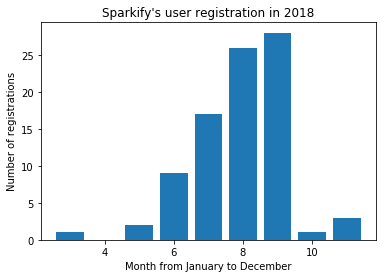

In [41]:
# bar chart of the registration time
plt.figure();
plt.bar(pd_reg_date.index, pd_reg_date["count"]);
plt.xlabel("Month from January to December");
plt.ylabel("Number of registrations");
plt.title("Sparkify's user registration in 2018");

## Feature creation

In this part the first features are created. The most important one is the churn rate.

#### Feature: Churn
The page event "Cancellaion Confirmation" is used to define the churn of the users.

In [42]:
def get_churn_feature(df):
    '''
    Input:
        df - (Spark dataframe) dataframe with Sparkify events
    Output:
        df - (Spark dataframe) return a dataframe including the userId and churn
        
    Description:
    This creates a new dataframe with an additional column for the churn rate, defined
    by the page event "Cancellation Confirmation".
    
    If a user once confirmed the cancellation chrurn is set to 1 for this user.
    '''
    # user defined function for set a churn indicator
    get_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

    # create new column churn
    df_churn = df.withColumn("churnEvent", get_churn(df.page))

    # create window with userId - this is needed to extract the churn users
    user_window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

    # create a new column churn, where a unique churn value is assigned to each user 
    df_churn = df_churn.withColumn("churn", F.max("churnEvent").over(user_window))

    return df_churn.select(["userId", "churn"]).dropDuplicates(["userId"])

#### Feature: Downgrade

In [43]:
def get_downgrade_feature(df):  
    '''
    Input:
        df - (Spark dataframe) dataframe with Sparkify events
    Output:
        df - (Spark dataframe) return a dataframe including the userId and information
             if the user performed a downgrade from a payed account to a free account
        
    Description:
    This creates a new dataframe with an additional column for the downgrade status, 
    defined by the page event "Downgrade".
    
    If a user once confirmed a downgrade this new variable is set to 1 for this user.
    '''
    # user defined function for indicating a downgrade event
    get_downgrade = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())

    # create temporary downgradeEvent column
    df_downgrade = df.withColumn("downgradeEvent", get_downgrade(df.page)) 

    # create window with userId - this is needed to extract the churn users
    user_window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    
    # create new column downgrade 
    df_downgrade = df_downgrade.withColumn("downgrade", F.max("downgradeEvent").over(user_window))
  
    return df_downgrade.select(["userId", "downgrade"]).dropDuplicates(["userId"])

#### Feature: Browser

In [44]:
def extract_os(userAgent):
    '''
    Input: 
        userAgent - (string) String including the used operating system
    Output:    
        (string) Name of the operating system
        
    Description:
    The user agent includes the used operating system which is extracted
    in this function.
    '''
    if "Windows" in userAgent:
        return "Windows"
    elif "Macintosh" in userAgent:
        return "MacOS"
    elif "iPhone" in userAgent:
        return "iPhone"
    elif "iPad" in userAgent:
        return "iPad"
    elif "Linux" in userAgent:
        return "Linux"
    else:
        np.nan

In [45]:
def get_os_feature(df):
    '''
    Input:
        df - (Spark dataframe) dataframe with Sparkify events
    Output:
        df - (Spark dataframe) return a dataframe including the userId and operating system (os)
    '''
    get_os = udf(lambda x: extract_os(x))
    return df.withColumn("os", get_os(df.userAgent)).select(["userId", "os"]).dropDuplicates(["userId"]) 

#### Feature: Operating system/device

In [46]:
def extract_browser(userAgent):
    '''
    Input: 
        userAgent - (string) String including the used operating system
    Output:    
        (string) Name of the used browser
        
    Description:
    The user agent includes the used browser which is extracted
    in this function.
    '''
    if "Firefox" in userAgent:
        return "Firefox"
    elif "Chrome" in userAgent:
        return "Chrome"
    elif "Safari" in userAgent:
        return "Safari"
    elif "Trident" in userAgent:
        return "InternetExplorer"
    else:
        return np.nan
    

In [47]:
def get_browser_feature(df):
    '''
    Input:
        df - (Spark dataframe) dataframe with Sparkify events
    Output:
        df - (Spark dataframe) return a dataframe including the userId and browser
    '''
    get_browser = udf(lambda x: extract_browser(x))
    return df.withColumn("browser", get_browser(df.userAgent)).select(["userId", "browser"]).dropDuplicates(["userId"])

In [48]:
def create_features(df):
    '''
    Input:
        df - (Spark dataframe) dataframe with Sparkify events
    Output:
        df - (Spark dataframe) return a dataframe with additional features (columns)
        
    Descriotion:
    This function creates the following features and adds them to the input dataframe.
    '''
    df_churn = get_churn_feature(df)
    df_downgrade = get_downgrade_feature(df)
    df_browser = get_browser_feature(df)
    df_os = get_os_feature(df)
    
    df = df.join(df_churn, on="userId", how="inner")\
           .join(df_downgrade, on="userId", how="inner")\
           .join(df_browser, on="userId", how="inner")\
           .join(df_os, on="userId", how="inner")
    return df

In [49]:
# add basic features (churn, downgrade, browser and os)
df = create_features(df)
df.persist()

DataFrame[userId: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, hour: int, churn: int, downgrade: int, browser: string, os: string]

In [50]:
# calculate the churn rate
churn_rate = df.dropDuplicates(["userId"]).where("churn = 1").count() / df.dropDuplicates(["userId"]).count()
print("The churn rate is {:.2f}%".format(churn_rate*100))

The churn rate is 23.11%


In [51]:
# calcuate the downgrade rate
downgrade_rate = df.dropDuplicates(["userId"]).where("downgrade = 1").count() / df.dropDuplicates(["userId"]).count()
print("The downgrade rate is {:.2f}%".format(downgrade_rate*100))

The downgrade rate is 68.44%


## Data Exploration
This section is a short exploratory data analysis the observe the behaviour the Sparkify's user who stayed vs who churned.

In [52]:
def plot_grouped_bar_chart(df, target_col, churn_col="churn", title="", xlabel="", ylabel="", size=[15,10]):
    '''
    Input:
        df - (Pandas dataframe) Dataframe with Sparkify records including churn
        target_col - (string) Name of the target variable/column 
        churn_col - (string) Name of the churn column
        title - (string) Title of the plot
        xlabel - (string) Label of the x-axis
        ylabel - (string) Label of the y-axis
        size - ([int,int]) Dimensions of the plot
    Output:
        none
        
    Description:
    This function creates a bar chart of a variable grouped by the churn rate.    
    '''
    # unstack grouped variables for plotting the data
    df_plot = df.groupby([target_col, churn_col]).sum().unstack().fillna(0)
    
    # get required data
    n_groups = df_plot.shape[0]
    variable_churn = df_plot["count"][1]
    variable = df_plot["count"][0]
    index_labels = df_plot.index

    # create plot
    fig, ax = plt.subplots(figsize=size)
    index = np.arange(n_groups)
    bar_width = 0.45
    opacity = 0.6
    plt.bar(index, variable, bar_width, alpha=opacity, color="green", label="Non Churn Users")
    plt.bar(index + bar_width, variable_churn, bar_width, alpha=opacity, color="red", label="Churn Users")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(index + bar_width, index_labels, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Churn in level (paid/unpaid)

In [53]:
# show the account level (paid/unpaid) regarding the churn rate
pd_level = df.dropDuplicates(["userId"]).groupby(["churn", "level"]).count().sort("churn").toPandas()
pd_level

,churn,level,count
0,0,free,133
1,0,paid,40
2,1,paid,8
3,1,free,44


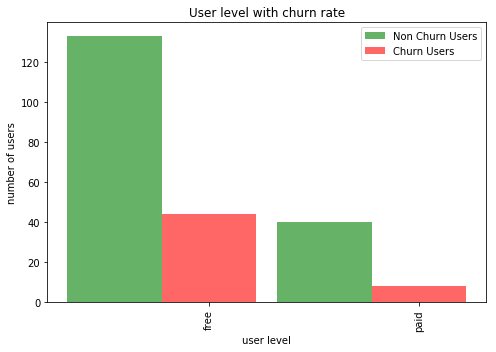

In [54]:
# create a grouped bar chart
plot_grouped_bar_chart(pd_level,
                       target_col = "level", 
                       churn_col = "churn", 
                       title = "User level with churn rate", 
                       xlabel = "user level",
                       ylabel = "number of users",
                       size = [7,5])

#### Churn in gender

In [55]:
# show the gender of the users grouped by churn
pd_gender = df.dropDuplicates(["userId"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
pd_gender

,churn,gender,count
0,0,M,89
1,0,F,84
2,1,F,20
3,1,M,32


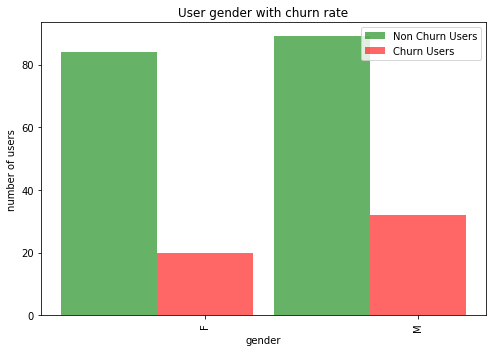

In [56]:
# create a grouped bar chart
plot_grouped_bar_chart(pd_gender,
                       target_col = "gender", 
                       churn_col = "churn", 
                       title = "User gender with churn rate", 
                       xlabel = "gender",
                       ylabel = "number of users",
                       size = [7,5])

#### Churn in user authentication

In [57]:
# check if the churn users were logged in 
pd_auth = df.groupby(["churn", "auth"]).count().sort("churn").toPandas()
pd_auth

,churn,auth,count
0,0,Logged In,233290
1,1,Cancelled,52
2,1,Logged In,44812


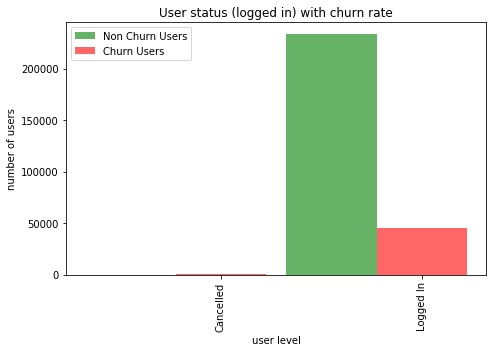

In [58]:
# create a grouped bar chart
plot_grouped_bar_chart(pd_auth,
                       target_col = "auth", 
                       churn_col = "churn", 
                       title = "User status (logged in) with churn rate", 
                       xlabel = "user level",
                       ylabel = "number of users",
                       size = [7,5])

#### Churn in location

In [59]:
# get user location grouped by chrun as pandas dataframe
pd_states = df.withColumn("state", split_location(df.location))\
                    .dropDuplicates(["userId"]).groupby(["churn", "state"])\
                    .count().sort("churn").toPandas()
pd_states.head()

,churn,state,count
0,0,FL,11
1,0,MN-WI,3
2,0,OK,1
3,0,TN,1
4,0,WV,1


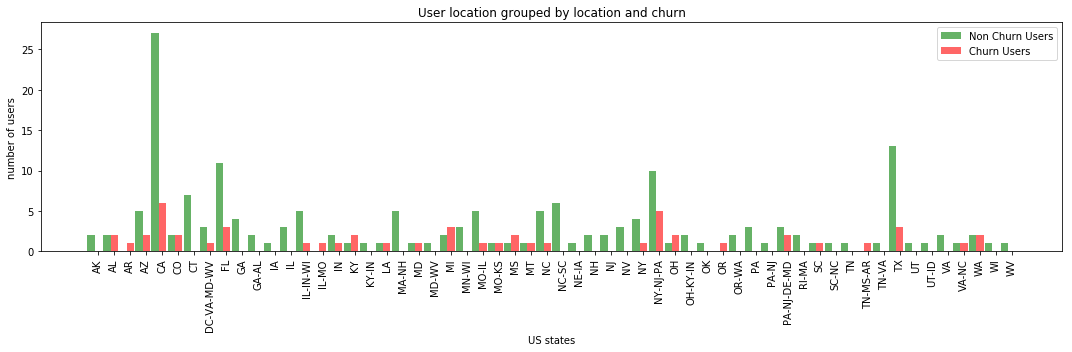

In [60]:
# create a grouped bar chart
plot_grouped_bar_chart(pd_states,
                       target_col = "state",
                       churn_col = "churn", 
                       title = "User location grouped by location and churn", 
                       xlabel = "US states", 
                       ylabel = "number of users" ,
                       size = [15,5])

#### Time between registration and unsubsrcribe request

In [61]:
# user defined function of calculating difference of two timestamps
udf_time = udf(lambda x: (x[1] - x[0]) if x[0] < x[1] else 0, IntegerType())

In [62]:
# add new column "churntime" -> hours between registration and confirmed cancellation
df_churn_time = df.where("page = 'Cancellation Confirmation'").select(["userId", "registration", "ts"])\
                        .withColumn("churntime", udf_time(struct('registration', 'ts')))\
                        .withColumn("churntime", F.abs(F.ceil(col("churntime")/1000/60/60))).drop("ts")

In [63]:
# calculate descriptives
df_churn_time.dropDuplicates(["userID"]).select("churntime").describe().show()

+-------+------------------+
|summary|         churntime|
+-------+------------------+
|  count|                52|
|   mean| 307.1730769230769|
| stddev|162.56000052515708|
|    min|                 2|
|    max|               563|
+-------+------------------+




The average churn time is 307.17 hours, which equals about 12.8 days. The longest churn time is only 2 hours where in contrast the longest duration is about 23.45 days

#### Playtime

In [64]:
# calculate playtime in minutes grouped by user churn
df.where(df.length.isNotNull()).groupby("length", "churn").count()\
.withColumn("time", (df.length * col("count"))/60).groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1| 9195|
|    0|14336|
+-----+-----+



In [65]:
print("Total total playtime for churn users: {:.2f} hours.".format(9195 / 60))
print("Total total playtime for non-churn users: {:.2f} hours.".format(14336 / 60))

Total total playtime for churn users: 153.25 hours.
Total total playtime for non-churn users: 238.93 hours.


#### Page roll advert

In [66]:
pd_advert = df.where("page = 'Roll Advert'").groupby(["page", "churn"]).count().toPandas()
pd_advert

,page,churn,count
0,Roll Advert,1,967
1,Roll Advert,0,2966


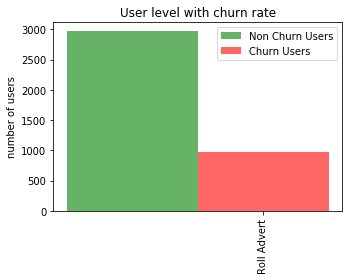

In [67]:
# create a grouped bar chart
plot_grouped_bar_chart(pd_advert,
                       target_col = "page", 
                       churn_col = "churn", 
                       title = "User level with churn rate", 
                       ylabel = "number of users",
                       size = [5,4])

#### Number of "NextSong" events

In [68]:
pd_next_song = df.where("page = 'NextSong'").select(["page", "churn"]).groupby(["page", "churn"]).count().toPandas()
pd_next_song

,page,churn,count
0,NextSong,0,191714
1,NextSong,1,36394


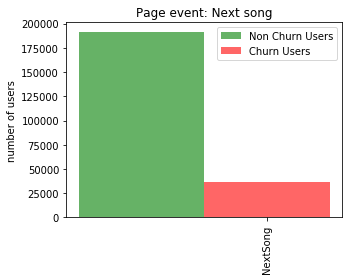

In [69]:
# create a grouped bar chart
plot_grouped_bar_chart(pd_next_song,
                       target_col = "page", 
                       churn_col = "churn", 
                       title = "Page event: Next song", 
                       xlabel = "",
                       ylabel = "number of users",
                       size = [5,4])

#### Number of added Friends on Sparkify

In [70]:
pd_friends = df.where("page = 'Add Friend'").select(["userId", "page", "churn"]).groupby(["page", "churn"]).count().toPandas()

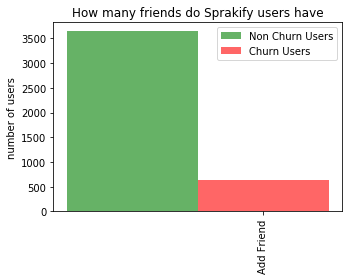

In [71]:
# create a grouped bar chart
plot_grouped_bar_chart(pd_friends,
                       target_col = "page", 
                       churn_col = "churn", 
                       title = "How many friends do Sprakify users have", 
                       ylabel = "number of users",
                       size = [5,4])

#### Number of thumbs up / thumbs down

In [72]:
pd_like_dislike = df.where("page = 'Thumbs Up' OR page = 'Thumbs Down'").groupby(["page", "churn"]).count().toPandas()
pd_like_dislike

,page,churn,count
0,Thumbs Up,0,10692
1,Thumbs Up,1,1859
2,Thumbs Down,0,2050
3,Thumbs Down,1,496


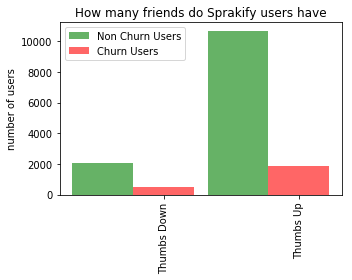

In [73]:
# create a grouped bar chart
plot_grouped_bar_chart(pd_like_dislike,
                       target_col = "page", 
                       churn_col = "churn", 
                       title = "How many friends do Sprakify users have", 
                       ylabel = "number of users",
                       size = [5,4])

#### Number of songs added to Playlist

In [74]:
pd_playlist = df.where("page = 'Add to Playlist'").groupby(["page", "churn"]).count().toPandas()
pd_playlist

,page,churn,count
0,Add to Playlist,1,1038
1,Add to Playlist,0,5488


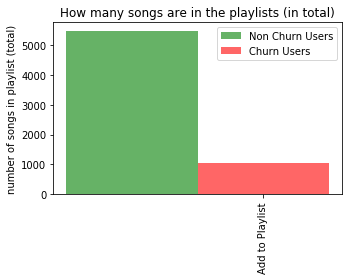

In [75]:
# create a grouped bar chart
plot_grouped_bar_chart(pd_playlist,
                       target_col = "page", 
                       churn_col = "churn", 
                       title = "How many songs are in the playlists (in total)", 
                       ylabel = "number of songs in playlist (total)",
                       size = [5,4])

#### Browser

In [76]:
# get brower data
pd_browser = df.groupby(["browser", "churn"]).count().toPandas()
pd_browser

,browser,churn,count
0,Safari,0,53895
1,Safari,1,7675
2,Firefox,1,14847
3,Chrome,1,20561
4,InternetExplorer,0,13566
5,Firefox,0,40799
6,InternetExplorer,1,1781
7,Chrome,0,125030


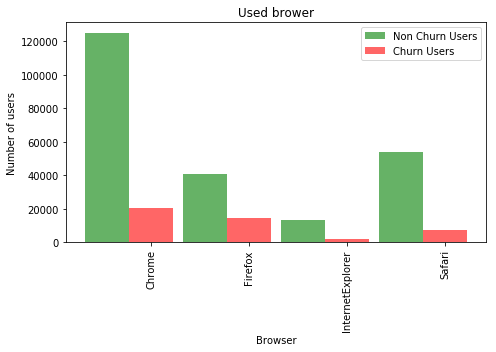

In [77]:
# create a grouped bar chart
plot_grouped_bar_chart(pd_browser, 
                       target_col = "browser",
                       churn_col = "churn", 
                       title = "Used brower",
                       xlabel = "Browser", 
                       ylabel = "Number of users",
                       size = [7,5])

#### Operating System (OS)

In [78]:
# get os data
pd_os = df.groupby(["os", "churn"]).count().toPandas()
pd_os

,os,churn,count
0,MacOS,1,17355
1,iPhone,1,1010
2,iPad,0,11381
3,Windows,0,119134
4,iPhone,0,10182
5,Linux,1,1762
6,Linux,0,7199
7,Windows,1,24737
8,MacOS,0,85394


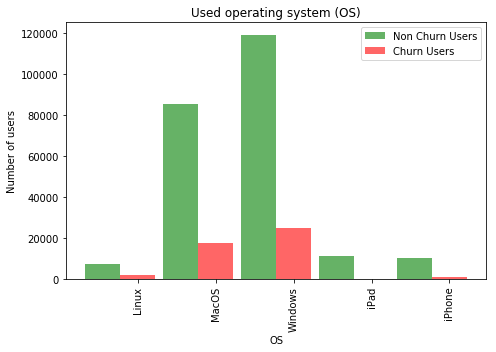

In [79]:
# create a grouped bar chart
plot_grouped_bar_chart(pd_os, 
                       target_col = "os",
                       churn_col = "churn", 
                       title = "Used operating system (OS)",
                       xlabel = "OS", 
                       ylabel = "Number of users",
                       size = [7,5])

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Features
The following features are created in the following section:

Categorical features:
* Level (paid / unpaid membership)
* Gender
* Downgrade (user performed a downgrade)
* Operating system
* Browser

Numerical features:
* Number of friends
* Number of Thumbs Up
* Number of Thumbs Down
* Number add to playlist
* Like-Dislike-Ratio (Thumbs Up / Thumbs down)
* How many days a user is registered
* Number of averege songs per session
* Number of rolled adverts

#### Feature Creation

In [80]:
def get_feature_dataframe(df):
    '''
    Input: 
    df - (pyspark dataframe) cleaned dataframe
    
    Output:
    df_result - (pyspark dataframe) dataframe with numerical features
    
    Description:
    This function computes several numerical features:
    - friends: Number of friends per Sparkify user
    - dislike: Number of dislikes
    - like: Number of likes
    - like-ration: ratio between likes and dislikes
    - churn-time: time from registration to churn in days
    - avg-songs-in-session: average amount of songs a user played in a session
    - advert: number of advert
    '''     
    df_friends = df.where("page = 'Add Friend'").groupby("userId").count().dropDuplicates(["userId"])\
                   .withColumn("numFriends", col("count")).drop("count")
        
    df_dislike = df.where("page = 'Thumbs Down'").groupby("userId").count().dropDuplicates(["userId"])\
                   .withColumn("numDislikes", col("count")).drop("count")

    df_like = df.where("page = 'Thumbs Up'").groupby("userId").count().dropDuplicates(["userId"])\
                .withColumn("numLikes", col("count")).drop("count")
    
    df_playlist = df.where("page = 'Add to Playlist'").groupby("userId").count().dropDuplicates(["userId"])\
                    .withColumn("playlistSize", col("count")).drop("count")
    
    df_likeRatio = df_dislike.join(df_like, on="userId", how="left")\
                             .withColumn("like-ratio", col("numLikes")/col("numDislikes"))
    
    df_time = df.groupby("userId").agg(F.max("ts").alias("last_access"))
    ms_per_day = 86400000 # milliseconds per day
    df_time = df_time.join(df, on="userId").withColumn("days", ((col("last_access")-col("registration"))/ms_per_day)\
                                                             .cast(IntegerType())).dropDuplicates(["userId"])\
                                                             .dropDuplicates(["userId"]).select("userId", "days")

    df_songs_in_session = df.groupby("userId", "ts").agg(max("itemInSession")).groupby("userId")\
                                                    .avg("max(itemInSession)")\
                                                    .withColumnRenamed("avg(max(itemInSession))", "avg_song_session")
    
    df_advert = df.where("page = 'Roll Advert'").groupby("userId").count().dropDuplicates(["userId"])\
                  .withColumn("numAdvert", col("count")).drop("count")
    
    df_result = df_friends.join(df_likeRatio, on="userId", how="inner")\
                          .join(df_playlist, on="userId", how="inner")\
                          .join(df_time, on="userId", how="inner")\
                          .join(df_songs_in_session, on="userId", how="inner")\
                          .join(df_advert, on="userId", how="inner")
    
    # add data for categorical features and add churn value
    df_result = df_result.join(df.select(["userId", "churn", "gender", "level", "downgrade", "os", "browser"]), on="userId", how="inner")

    return df_result.dropDuplicates(["userId"])

In [81]:
# calculate numerical features
df_features = get_feature_dataframe(df)

In [82]:
# clear cache
spark.catalog.clearCache()
# perist feature dataframe
df_features.persist()

DataFrame[userId: string, numFriends: bigint, numDislikes: bigint, numLikes: bigint, like-ratio: double, playlistSize: bigint, days: int, avg_song_session: double, numAdvert: bigint, churn: int, gender: string, level: string, downgrade: int, os: string, browser: string]

In [83]:
# print dataframe schema
df_features.printSchema()

root
 |-- userId: string (nullable = true)
 |-- numFriends: long (nullable = false)
 |-- numDislikes: long (nullable = false)
 |-- numLikes: long (nullable = true)
 |-- like-ratio: double (nullable = true)
 |-- playlistSize: long (nullable = false)
 |-- days: integer (nullable = true)
 |-- avg_song_session: double (nullable = true)
 |-- numAdvert: long (nullable = false)
 |-- churn: integer (nullable = true)
 |-- gender: string (nullable = false)
 |-- level: string (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- os: string (nullable = true)
 |-- browser: string (nullable = true)



# Modeling
In this section the dataset will be divided into train and test sets and these datasets are used to compare different ML approaches for predicting Sparkify users churn behaviour.

For this classification problem the following classifiers are used:
* Logistic Regression
* Decision Trees
* Gradient Boosting Trees
* SVM

Cross validation is used to find the best model parameters.

## Create dataset for the Model
Convert the dataset ```df_features``` into a dataset which can directly be used in ML models using a Vector Assembler and Features Scaler (using StandardScaler).

#### Function definition for model creation

In [84]:
# list of numerical features
numerical_features = ["numFriends", "numDislikes", "numLikes", "like-ratio", "playlistSize", "days", 
                      "avg_song_session", "numAdvert", "downgrade"] 

# list of categorical features
categorical_features = ["genderFeat", "levelFeat", "downgradeFeat", "osFeat", "browserFeat"]

In [85]:
def create_categorical_features(df, columns_list):
    '''
    Input:
        columns_list - (list) column names of categorical features 
        df - (pyspark dataframe) dataframe

    Output:
        df - (pyspark dataframe) dataframe with categorical features

    Desciption:
    For each element in the columns list a categorical feature will
    be created using a StringIndexer.
    The original columns in columns_list will be replaced with the
    feature.
    '''
    for col in columns_list:
        indexer = StringIndexer(inputCol=col[:-4], outputCol=col)
        df = indexer.fit(df).transform(df)
    return df

In [86]:
def create_preprocessing_pipeline(numerical_features = numerical_features, categorical_features = categorical_features):
    '''
    Input:
        numerical_features - (list) a list of strings naming the columns of numerical features
        categorical_features - (list) a list of strings naming the columns of categorical features

    Output:
        pipeline - (pyspark pipeline) a pipeline which includes all necessary processing steps, including a 
                   VetorAssembler and a Standard Scaler

    Description:
    Build a pyspark pipeline for transforming the data in the desired layout.
    Important note: the categorical features were already converted using a String Indexer in a previous step.
    '''
    # numieric features: feature vectorizer and scaler 
    assembler_num = VectorAssembler(inputCols = numerical_features, 
                                    outputCol = "numerical_features")
    
    feature_scaler_num = StandardScaler(withMean = True, withStd = True, 
                                   inputCol = "numerical_features", 
                                   outputCol = "scaled_features")

    # categorical features: 
    assembler_cat = VectorAssembler(inputCols = categorical_features+["scaled_features"], 
                                    outputCol = "features")
    
    # create pipeline
    pipeline = Pipeline(stages = [assembler_num, feature_scaler_num, assembler_cat])
    
    return pipeline

In [87]:
def create_model_dataset(df, numerical_features = numerical_features, categorical_features = categorical_features):
    '''
    Input:
        df_features - (pyspark dataframe) a dataframe which includes all features
        numerical_features - (list) a list of strings naming the columns of numerical features
        categorical_features - (list) a list of strings naming the columns of categorical features
    
    Output:
        df - (pyspark dataframe) which includes all columns from the input dataset, but extendet 
             with the features in an additional representation (defined with pipeline)
    '''
    # create categorical features
    df = create_categorical_features(df, categorical_features)
    
    # create the pipeline
    pipeline = create_preprocessing_pipeline(numerical_features, categorical_features)

    # fit and transform the data
    df = pipeline.fit(df).transform(df)
    
    # rename column churn into label (label is more common usage in ML algorithms) 
    df = df.withColumnRenamed("churn", "label")
    
    return df.select(["label", "features"])

In [88]:
def save_model(df, filename = "model_data"):
    '''
    Input:
        df - (Spark dataframe) dataframe for model creation
        filename - (string) name of the pickle file
    
    Description:
    Save the model created model dataframe as a pickle file. This is a convenient
    way to skip all the time consuming preprocessing steps.
    Attention: Only the label and the features will be saved.
    '''
    # save the model as pickle file
    df_model.select(["label", "features"]).rdd.saveAsPickleFile(filename)    

In [89]:
def load_model(sparkSession = spark, filename = "model_data"):
    '''
    Input: 
        spar - (Spark session) current spark session
        filename - (string) Filename of the saved model (pickle file)
        
    Output:
        df - (Spark dataframe) returns the loaded model dataframe
    '''
    # load the pickle file
    pickleRdd = spark.sparkContext.pickleFile(filename).collect()
    # create spark dataframe
    df = spark.createDataFrame(pickleRdd)
    return df

#### Create the model dataset


In [90]:
# create model dataset
df_model = create_model_dataset(df_features, numerical_features, categorical_features)

In [91]:
# clear cache
spark.catalog.clearCache()
# cache model dataframe
df_model.persist()

DataFrame[label: int, features: vector]

In [93]:
# save the model as pickle file
save_model(df_model, filename = "model_data")

In [94]:
# load the saved dataframe
df_model = load_model(sparkSession = spark, filename = "model_data")

## Model creation
In this section the different Machine Learning approaches are used for predicting Sparkify's user data.

#### Function defintion for model creation and comparison

In [95]:
def create_cross_validator(classifier):
    '''
    Input:
        classifier - (string) Name of the classifier
    
    Output:
        crossval - (spark.ml.tuning.crossvalidator) Crossvalidator for the classifier
    
    Description:
    This function creats a crossvalidator for the classifiert, this includes the creation
    of the classifiert itself and the parameter grid.
    '''
    # create model 
    if classifier == "LogisticRegression":
        clf = LogisticRegression()
        
        paramGrid = ParamGridBuilder() \
                        .addGrid(clf.maxIter, [10, 100]) \
                        .addGrid(clf.regParam, [0.1, 0.01]) \
                        .addGrid(clf.fitIntercept, [False, True])\
                        .addGrid(clf.elasticNetParam, [0.0, 0.1])\
                        .build()
    
    elif classifier == "RandomForestClassifier":
        clf = RandomForestClassifier()
        paramGrid = ParamGridBuilder() \
                        .addGrid(clf.maxDepth, [2, 8]) \
                        .addGrid(clf.numTrees, [5, 10]) \
                        .addGrid(clf.impurity, ["gini", "entropy"]) \
                        .build()
        
    elif classifier == "GBTClassifier":
        clf = GBTClassifier()
        
        paramGrid = ParamGridBuilder() \
                        .addGrid(clf.maxIter, [10, 100]) \
                        .addGrid(clf.maxDepth, [2, 8]) \
                        .build()
 
    elif classifier == "LinearSVC":
        clf = LinearSVC()
        
        paramGrid = ParamGridBuilder() \
                        .addGrid(clf.maxIter, [10, 100]) \
                        .build()
 
    else:
        return "Error: Invalid model."
    
    # create Cross-Validator with current classifier and parameter grid
    crossval = CrossValidator(estimator=clf,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=4) 
    return crossval

In [96]:
def create_and_evaluate_model(classifier, train, test):
    '''
    Input:
        classifier - (string) name of a classifier
        train - (Spark dataframe) training data
        test - (Spark dataframe) test data
        
    Output:
        f1_score - (float) returns the f1-score of the created model
        accuracy - (float) returns the accuracy of the created model
    
    Description:
    Create a model depending on the choosen classifier. Train the model and    
    find the best hyperparameters using a cross validator and parameter grid.
    
    After the model is created the model will tested against unknown test
    data. The performance is measured by the f1-score and the accuracy.
    '''
    # create cross validator for the classifier
    crossval = create_cross_validator(classifier)

    # train the model
    model = crossval.fit(train)

    # make prediction for unknown test data
    predictions = model.transform(test)
    
    # select (prediction, label) and compute test error
    evaluator = MulticlassClassificationEvaluator(metricName = "f1",
                                                  labelCol = "label",
                                                  predictionCol = "prediction")
    
    # compute f1 score
    f1_score = evaluator.evaluate(predictions)
    
    # compute accuracy
    evaluator.setMetricName("accuracy")
    accuracy = evaluator.evaluate(predictions)

    # print stats
    print("Classifier: {} - F1-Score: {:.2f} - accuracy: {:.2f}".format(classifier, f1_score, accuracy))
    
    return f1_score, accuracy

In [97]:
def compare_classifier(df, classifier=["LinearSVC", "GBTClassifier", "RandomForestClassifier", "LogisticRegression"]):
    '''
    Input:
        df - (Spark dataframe) Dataframe of the model. It must include the columns "label" and "features"
        classifier - (list(string)) List with classifier names
        
    Output:
        none
        
    Description:
    Compare all classifier in classifier list.    
    '''
    # split the model data into train and test-set
    train, test = df.randomSplit([0.8, 0.2], seed=42)
    train.persist()
    test.persist()
    
    
    # test all models in classifier list
    for clf in classifier:
        create_and_evaluate_model(clf, train, test)

#### Build and compare the models

In [98]:
# run the classifier comparision
compare_classifier(df_model, classifier=["LogisticRegression", "RandomForestClassifier", "GBTClassifier", "LinearSVC"])

Classifier: LogisticRegression - F1-Score: 0.79 - accuracy: 0.80
Classifier: RandomForestClassifier - F1-Score: 0.77 - accuracy: 0.80
Classifier: GBTClassifier - F1-Score: 0.77 - accuracy: 0.80
Classifier: LinearSVC - F1-Score: 0.77 - accuracy: 0.80


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.